# Objective

1. Given data for the last N days of ETF pricing data, this model aims to predict for the N + H days in the future
2. Utilizing Prophet & LSTM as models to forecast time-series data

In [16]:
import pandas as pd
import numpy as np
import time
import math
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from fbprophet import Prophet

In [5]:
# reading the dataset
# 5 years worth of pricing data
df = pd.read_csv('SPY.csv')

# convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d')

# remove spaces in col headers
df.columns = [str(i).lower().replace(' ','_') for i in df.columns]

# sort values by datetime
df.sort_values(by = 'date', inplace = True, ascending = True)

df.head()

,date,open,high,low,close,adj_close,volume
0,2015-06-15,208.639999,209.449997,207.789993,209.110001,189.227280,124384200
1,2015-06-16,208.929993,210.350006,208.720001,210.250000,190.258896,85308200
2,2015-06-17,210.589996,211.320007,209.360001,210.589996,190.566559,126708600
3,2015-06-18,211.309998,213.339996,210.630005,212.779999,192.548340,165867900
4,2015-06-19,211.460007,211.550003,210.360001,210.809998,191.693558,130478700


Text(0, 0.5, 'USD')

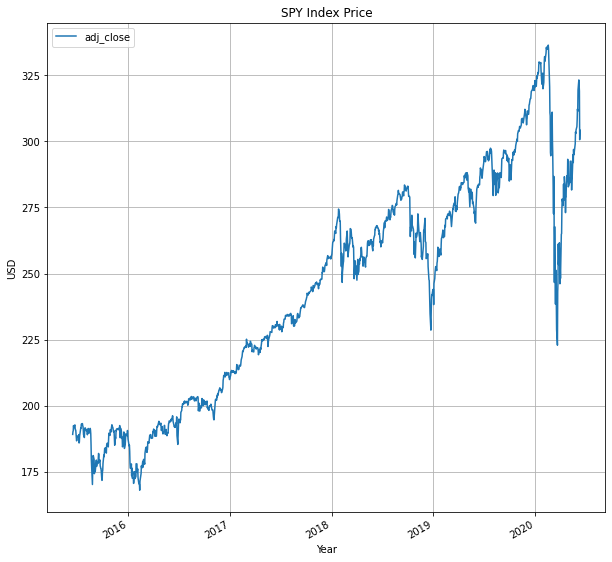

In [6]:
# Plot adjusted closing price of ETF over time
plt = df.plot(x = 'date', y = 'adj_close', linestyle='-', figsize = [10,10], grid = True)
plt.set_title('SPY Index Price')
plt.set_xlabel('Year')
plt.set_ylabel('USD')

### Preparing for Prophet
Prophet takes in 2 columns as default, which are ds and the y value. These 2 columns must be present be fed to the Prophet model.

In [8]:
# based on historical data, we want to predict prices for the next 30 days, which will be the forecast horizon
H = 30

In [9]:
# Fitting Prophet model
m = Prophet()
m.fit(df_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [10]:
# Create new dataframe with dates we want to predict
future = m.make_future_dataframe(periods = H)

In [11]:
# remove weekends from future dataframe, since we do not need to predict weekend data
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.weekday.html
# https://facebook.github.io/prophet/docs/non-daily_data.html

future['day'] = future['ds'].dt.weekday
future = future[future['day'] <5]

forecast = m.predict(future)

In [12]:
# double check if we have values for future predictions
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1274,2020-07-06,299.920586,286.415346,312.460225
1275,2020-07-07,300.550740,287.852662,312.931311
1276,2020-07-08,300.707556,287.574508,312.863464
1277,2020-07-09,301.050752,288.477687,312.906886
1278,2020-07-10,301.360097,288.473042,312.125367


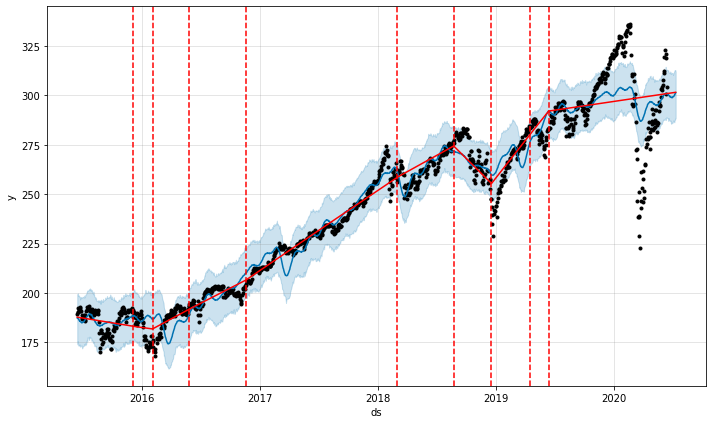

In [13]:
# plot the forecast
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast);

# add changepoints
a = add_changepoints_to_plot(fig.gca(), m, forecast)

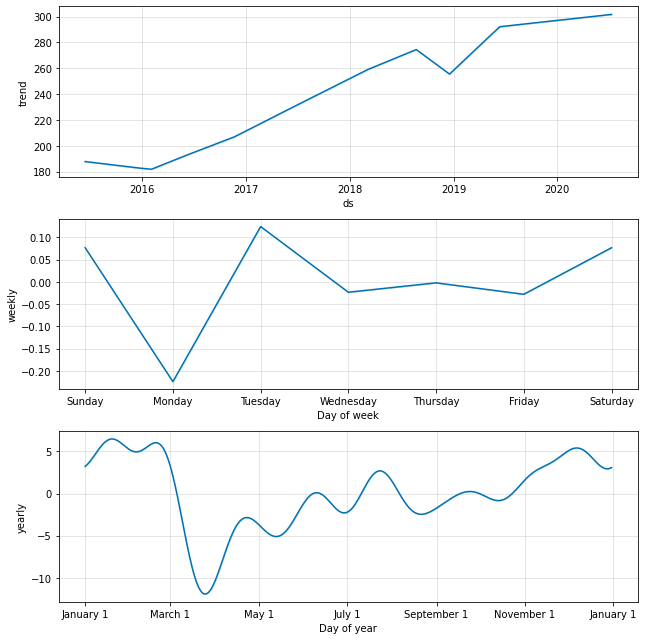

In [14]:
# plot components
m.plot_components(forecast);

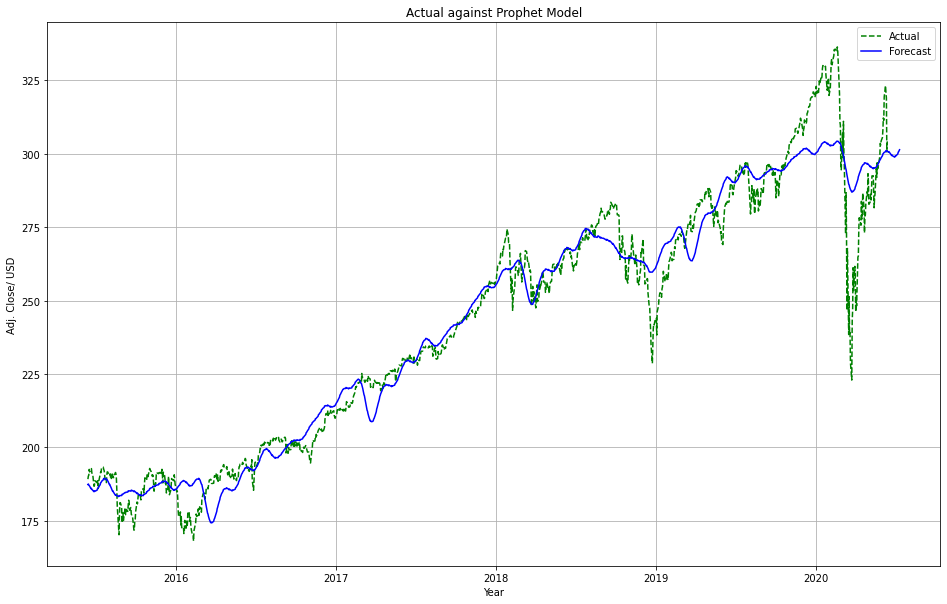

In [17]:
# Plotting the acutal plot against the forecast
plt.rcParams["figure.figsize"] = [16,10]
fig, ax = plt.subplots()
ax.plot('date','adj_close', linestyle='--', color='g', data = df)
ax.plot('ds', 'yhat', linestyle='-', color='b', data = forecast)

ax.set_title('Actual against Prophet Model')
ax.legend(['Actual','Forecast'])
ax.xaxis.set_label_text('Year')
ax.yaxis.set_label_text('Adj. Close/ USD')
ax.grid(True)
plt.show()

## Tweaking the model

From the plot above, the forecasted model does generally follow the acutal data, but we want to improve the prediction accuracy of the Prophet model to get a more reliable forecast of future values. 

In [18]:
# Evaluating accuracy of time series model with error metrics 
# Use these metrics to evaluate our prediction accuracy

# MAPE - mean absolute percentage error
def get_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# MAE - mean absolute error
def get_mae(x, y):
    return np.mean(abs(np.array(x)-np.array(y)))

# RMSE - root mean squared error
def get_rmse(x, y):
    return math.sqrt(np.mean((np.array(x)-np.array(y))**2))

In [19]:
# Compare original dataframe and forecast model
print("MAPE: " + str(get_mape(df['adj_close'], forecast['yhat'][:-20])) + '\n' +
      "MAE: " + str(get_mae(df['adj_close'], forecast['yhat'][:-20])) + '\n' +
      "RMSE: " + str(get_rmse(df['adj_close'], forecast['yhat'][:-20]))
)

MAPE: 2.694284813514794
MAE: 6.558316223460894
RMSE: 9.664222949035862


# Tuning the model
https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3
https://www.analyticsvidhya.com/blog/2018/05/generate-accurate-forecasts-facebook-prophet-python-r/

In [26]:
# Count the total possible models that can arrive from the various model tuning parameters
# Parameters such as mode of seasonality, fourier order, the number of changepoints and their scale

from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'fourier_order':[1 , 2, 3, 4, 5],
               'changepoint_prior_scale':[0.05, 0.1, 0.5, 1, 1.5, 2],
              'n_changepoints' : [100,150,200]}
grid = ParameterGrid(params_grid)
count = 0
for p in grid:
    count = count+1

print('Total Possible Models',count)

Total Possible Models 180


In [22]:
# Prophet model tuning
model_parameters = pd.DataFrame(columns = ['MAPE', 'MAE', 'RMSE', 'Parameters'])

start = time.time()
counter = 0

for p in tqdm(grid):
    random.seed(10)
    m = Prophet(seasonality_mode = p['seasonality_mode'],
                          changepoint_prior_scale = p['changepoint_prior_scale'],
                          n_changepoints = p['n_changepoints'],
                          daily_seasonality = True,
                          weekly_seasonality = True,
                          yearly_seasonality = True, 
                          interval_width = 0.95)
    
    #iterate through fourier_order
    m.add_seasonality(name='monthly', period=H, fourier_order= int(p['fourier_order']))
                
    # fit our Prophet-ready dataframe
    m.fit(df_prophet)
    future = m.make_future_dataframe(periods = H)
    
    # remove weekends from our dataframe
    future['day'] = future['ds'].dt.weekday
    future = future[future['day'] <5]
    forecast = m.predict(future)
    
    # compute error metrics
    MAPE = get_mape(df['adj_close'], forecast['yhat'][:-20])
    MAE = get_mae(df['adj_close'], forecast['yhat'][:-20])
    RMSE = get_rmse(df['adj_close'], forecast['yhat'][:-20])
    
    # increase counter
    counter +=1    
    model_parameters = model_parameters.append({'MAPE':MAPE, 'MAE':MAE, 'RMSE':RMSE, 'Parameters':p}, 
                                               ignore_index=True)
    
end = time.time()
print("Time taken:" + end-start)

100%|██████████| 180/180 [1:24:36<00:00, 28.20s/it]


TypeError: can only concatenate str (not "float") to str

In [25]:
# Export results to CSV
model_parameters.to_csv('tuning_results.csv')

# Sort parameters by descending MAPE
model_parameters.sort_values(by = ['MAPE', 'MAE', 'RMSE'])

# Model 148 provides the best results
grid[147]

{'seasonality_mode': 'additive',
 'n_changepoints': 150,
 'fourier_order': 5,
 'changepoint_prior_scale': 1.5}

In [38]:
# Train final model with parameters
final_model = Prophet(seasonality_mode='additive', n_changepoints= 150, changepoint_prior_scale = 1.5)
final_model.add_seasonality(name='monthly', period=H, fourier_order= 5)

# Fit final model
final_model.fit(df_prophet)
future = final_model.make_future_dataframe(periods = H)

# remove weekends
future['day'] = future['ds'].dt.weekday
future = future[future['day'] <5]
forecast_final = final_model.predict(future)
forecast_final.head()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-06-15,184.723706,183.684765,193.626824,184.723706,184.723706,4.018911,4.018911,4.018911,-0.191863,...,0.724042,0.724042,0.724042,3.486732,3.486732,3.486732,0.0,0.0,0.0,188.742617
1,2015-06-16,184.580179,184.166970,193.891136,184.580179,184.580179,4.506637,4.506637,4.506637,-0.282388,...,0.952540,0.952540,0.952540,3.836485,3.836485,3.836485,0.0,0.0,0.0,189.086815
2,2015-06-17,184.436651,184.252350,194.500588,184.436651,184.436651,4.808631,4.808631,4.808631,-0.389210,...,1.049311,1.049311,1.049311,4.148530,4.148530,4.148530,0.0,0.0,0.0,189.245282
3,2015-06-18,184.293124,184.054642,194.612373,184.293124,184.293124,5.034075,5.034075,5.034075,-0.339252,...,0.948236,0.948236,0.948236,4.425092,4.425092,4.425092,0.0,0.0,0.0,189.327199
4,2015-06-19,184.149596,184.592502,194.480944,184.149596,184.149596,5.474689,5.474689,5.474689,-0.106921,...,0.912758,0.912758,0.912758,4.668852,4.668852,4.668852,0.0,0.0,0.0,189.624285


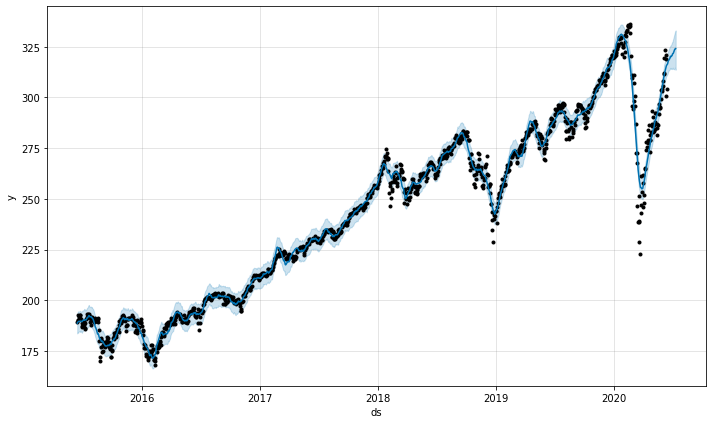

In [40]:
# plot graphs
fig2 = final_model.plot(forecast_final);

In [51]:
# with changepoints
a = add_changepoints_to_plot(fig2.gca(), m, forecast_final)

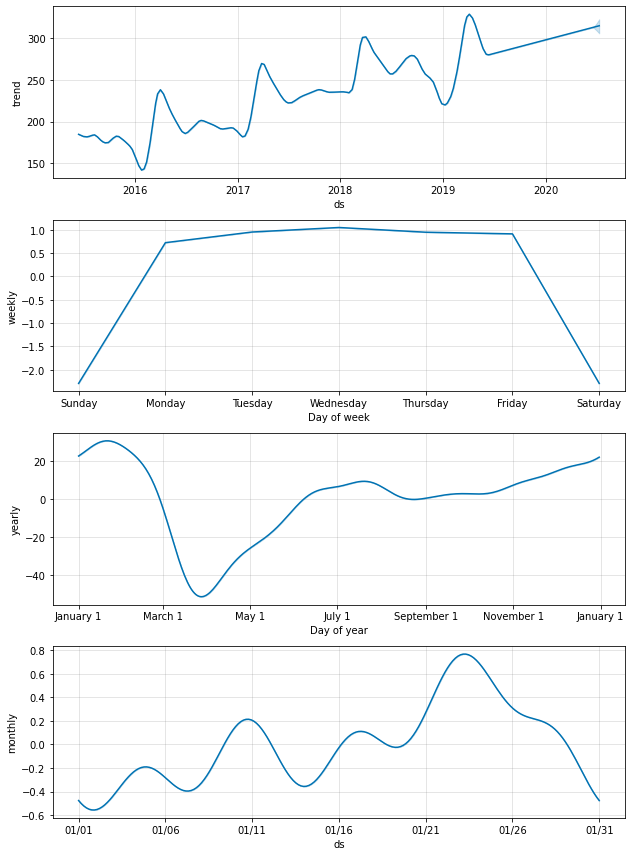

In [52]:
# plot components
final_model.plot_components(forecast_final);

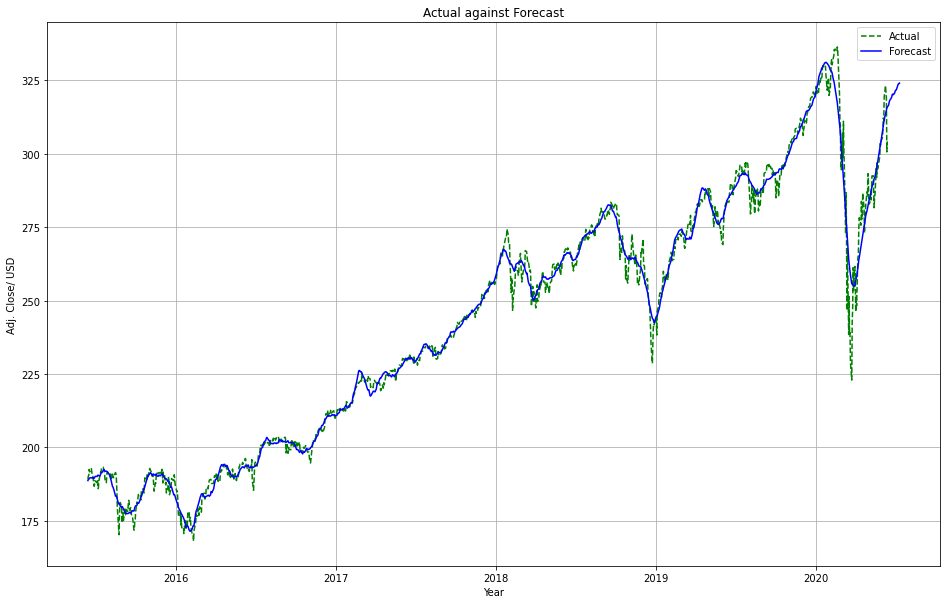

In [54]:
# plotting final model against actual data
plt.rcParams["figure.figsize"] = [16,10]
fig, ax = plt.subplots()
ax.plot('date','adj_close', linestyle='--', color='g', data = df)
ax.plot('ds', 'yhat', linestyle = '-', color='b', data = forecast_final)

ax.set_title('Actual against Forecast')
ax.legend(['Actual','Forecast'])
ax.xaxis.set_label_text('Year')
ax.yaxis.set_label_text('Adj. Close/ USD')
ax.grid(True)
plt.show()

In [49]:
start_dt = '2020-06-15'

In [47]:
forecasts= forecast_final[(forecast_final.ds >= start_dt)]

In [50]:
forecasts.yhat

1259    316.541113
1260    317.299703
1261    317.949655
1262    318.252318
1263    318.436155
1264    319.204003
1265    319.906659
1266    320.277136
1267    320.200737
1268    320.102249
1269    320.729137
1270    321.304402
1271    321.590090
1272    321.634650
1273    321.888317
1274    323.233839
1275    323.688471
1276    323.867680
1277    323.872860
1278    324.046638
Name: yhat, dtype: float64